# Analysis Education Zones


## Steps

    [*] Get The Data
    [*] Simple Descriptive :
        [*] Overall
        [*] last sync Descriptive
        [*] SD, SMP, SMA Portion
        [*] School Numbers
        [] Most Sparse Province in terms of school number
    [*] Mapping :
        [*] Example map with point
        [*] Example Radius
        [*] Example School Number Heatmap
    [*] Questions :
        [*] From top cities, Avg number of school for every person?
        [*] From top cities, what is percentage area coverage for different radius
        [*] Voronoi and clustering?
        
<!-- DKI Jakarta, Kota Surabaya, Kota Medan, Kota Bandung, Kota Makassar, Kota Palembang -->
<!-- https://ilmupengetahuanumum.com/10-kota-terbesar-di-indonesia-menurut-jumlah-penduduknya/ -->
<!-- https://ilmugeografi.com/ilmu-sosial/kota-terpadat-di-indonesia -->


In [411]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# https://medium.com/tinghaochen/install-geopandas-on-macos-mojave-32c0ab0b7d18
import geopandas as gpd
from geopandas import GeoSeries
import geoplot.crs as gcrs
import fiona
from shapely.geometry import LineString, Polygon, Point
import numpy as np

import shapely
import descartes
import Levenshtein
# import geog
import shapely.geometry
import geoplot
import matplotlib
import pyproj
from shapely.ops import transform
from functools import partial


from ipywidgets import *
from IPython.display import display, HTML
import ipywidgets as widgets


from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture


# https://github.com/WZBSocialScienceCenter/geovoronoi
from geovoronoi import voronoi_regions_from_coords
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi._voronoi import get_points_to_poly_assignments
import random

import randomcolor

In [2]:
PATH_PROCESSED='../data/processed/'
PATH_INTERIM='../data/interim/'
PATH_MODEL="../models/"

## Get Data

In [3]:
data_skul=pd.read_csv(PATH_PROCESSED+'20190901_all_sekolah_genap2019_data_latlong.csv')
map_reference=pd.read_csv(PATH_INTERIM+'reference_our_data_to_map_used.csv')
map_reference.columns=['kab_kota','NAME_2','Lev_Ratio','Inter_Ratio','Rank','Rank2']

In [4]:
data_skul.head()

,provinsi,kab_kota,kecamatan,nama_sekolah,npsn,bp,status,last_sync,jml_sync,pd,rombel,guru,pegawai,ruang_kelas,ruang_lab,ruang_perpus,url_sekolah,coordinate,lintang,bujur
0,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD N SEUNEUBOK TEUNGOH,10107900,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3594000,Bujur : 95.9281000",4.3594,95.9281
1,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE BATEE,10110676,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3453000,Bujur : 95.9736000",4.3453,95.9736
2,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE SUNDAK,10110270,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3257000,Bujur : 95.9761000",4.3257,95.9761
3,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ARONGAN WOYLA,10107859,SD,Negeri,-,0,0.0,0,0,0,6,0,0,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.2994000,Bujur : 95.9536000",4.2994,95.9536
4,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI COT BULOH,10107863,SD,Negeri,-,0,0.0,0,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3252000,Bujur : 95.9576000",4.3252,95.9576


In [5]:
data_skul['is_updated']=(data_skul.last_sync!='-').astype(int)

In [6]:
data_skul.sample(10)

,provinsi,kab_kota,kecamatan,nama_sekolah,npsn,bp,status,last_sync,jml_sync,pd,...,guru,pegawai,ruang_kelas,ruang_lab,ruang_perpus,url_sekolah,coordinate,lintang,bujur,is_updated
10704,Prov. Jawa Barat,Kab. Bogor,Kec. Bojong Gede,SD ISLAM DAARUS SHOFWAH,69969604,SD,Swasta,-,0,0.0,...,0,0,7,1,2,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -6.4413080,Bujur : 106.7868240",-6.441308,106.786824,0
129488,Prov. Jawa Timur,Kab. Nganjuk,Kec. Prambon,SD NEGERI 1 KURUNGREJO,20538011,SD,Negeri,-,0,0.0,...,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -7.6640000,Bujur : 112.0272000",-7.664000,112.027200,0
5458,Prov. Aceh,Kab. Bener Meriah,Kec. Timang Gajah,SD NEGERI CEKAL,10105187,SD,Negeri,-,0,0.0,...,0,0,7,0,0,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.7632000,Bujur : 96.7034000",4.763200,96.703400,0
7120,Prov. Kalimantan Timur,Kab. Berau,Kec. Biduk Biduk,SMP NEGERI 2 BIDUK-BIDUK,30405580,SMP,Negeri,-,0,0.0,...,0,0,3,2,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 1.2884167,Bujur : 118.6509778",1.288417,118.650978,0
152665,Prov. Nusa Tenggara Timur,Kab. Ngada,Kec. Golewa Barat,SD INPRES TUREKISA,50303156,SD,Negeri,-,0,0.0,...,0,0,20,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -8.8124000,Bujur : 121.0027000",-8.812400,121.002700,0
207950,Prov. Banten,Kab. Tangerang,Kec. Rajeg,SD NEGERI SUKASARI 4,20603411,SD,Negeri,-,0,0.0,...,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -6.1162000,Bujur : 106.5495000",-6.116200,106.549500,0
166455,Prov. Jawa Barat,Kab. Subang,Kec. Subang,SD ISLAM TERPADU AL-FURQON SUKAJADI,69896178,SD,Swasta,-,0,0.0,...,0,0,6,0,0,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -6.5621370,Bujur : 107.7634190",-6.562137,107.763419,0
13432,Prov. Jawa Barat,Kab. Bogor,Kec. Sukaraja,SMP ISLAM AZIZUR RASYID,69919436,SMP,Swasta,-,0,0.0,...,0,0,3,0,0,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -6.6385000,Bujur : 106.8501000",-6.638500,106.850100,0
96358,Prov. Jawa Timur,Kab. Malang,Kec. Tumpang,SD NEGERI 4 DUWET,20518770,SD,Negeri,-,0,0.0,...,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : -8.0237000,Bujur : 112.7850000",-8.023700,112.785000,0
939,Prov. Aceh,Kab. Aceh Selatan,Kec. Kluet Tengah,SD NEGERI 2 MENGGAMAT,10102668,SD,Negeri,-,0,0.0,...,0,0,6,0,1,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 3.3436000,Bujur : 97.3611000",3.343600,97.361100,0


In [7]:
map_reference.head()

,kab_kota,NAME_2,Lev_Ratio,Inter_Ratio,Rank,Rank2
0,Kab. Aceh Barat,Aceh Barat,0.800000,1.000000,1.0,1.0
1,Kab. Aceh Barat Daya,Aceh Barat Daya,0.857143,1.000000,1.0,1.0
2,Kab. Aceh Besar,Aceh Besar,0.800000,1.000000,1.0,1.0
3,Kab. Aceh Jaya,Aceh Jaya,0.782609,0.989796,1.0,1.0
4,Kab. Aceh Selatan,Aceh Selatan,0.827586,0.995098,1.0,1.0


In [8]:
fp = PATH_MODEL+'gadm36_IDN_shp/gadm36_IDN_2.shp'
map_df = gpd.read_file(fp)

## Simple Descriptive 

#### 1. Overall

In [9]:
# overall
data_skul.shape

(218135, 21)

In [10]:
len(data_skul.provinsi.unique())

34

In [11]:
len(data_skul.kecamatan.unique())

6683

#### 2. last sync Descriptive

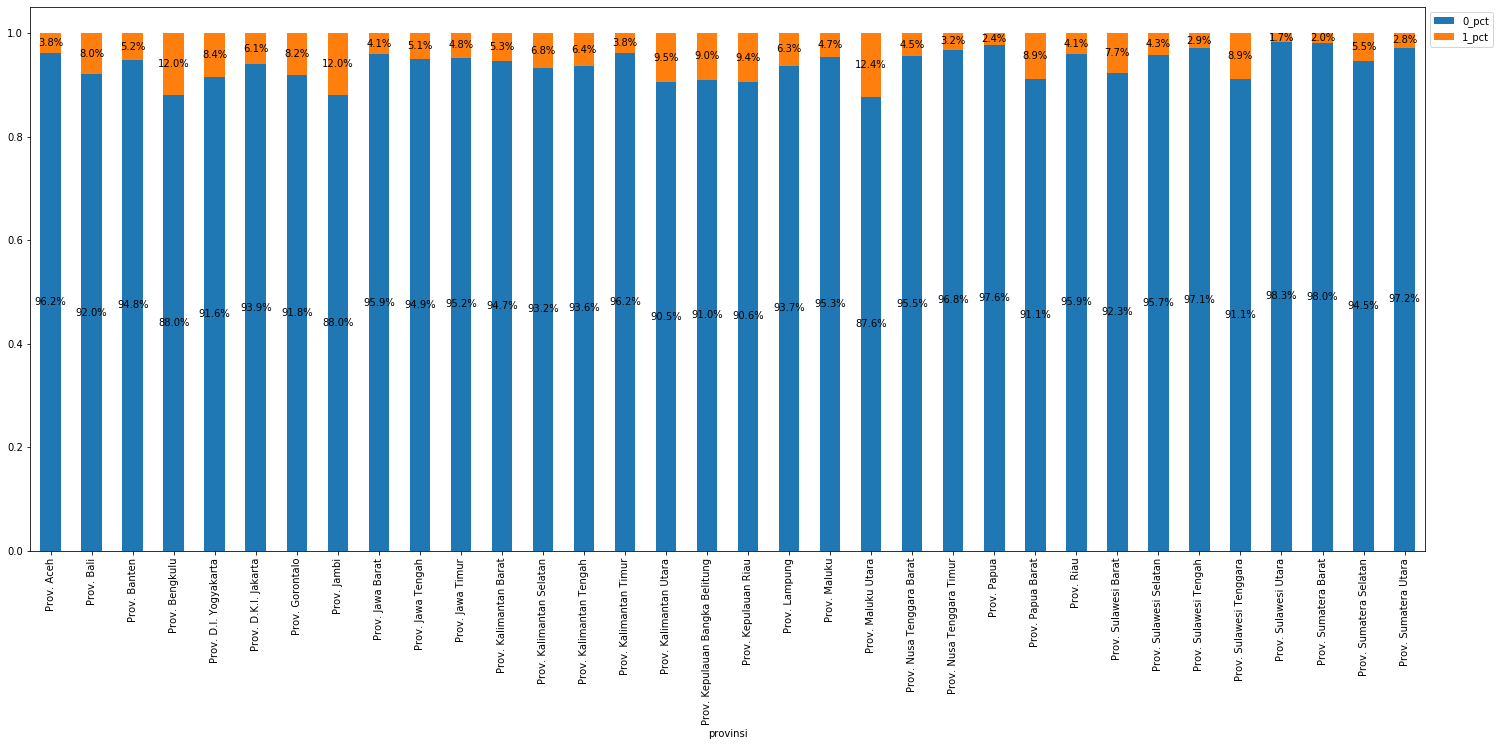

In [12]:
data_update_skul=data_skul.groupby(['provinsi','is_updated']).size().unstack()
data_update_skul['0_pct']=data_update_skul[0]/data_update_skul.sum(axis=1)
data_update_skul['1_pct']=data_update_skul[1]/data_update_skul.sum(axis=1)
ax=data_update_skul[['0_pct','1_pct']].plot(kind='bar', stacked=True, figsize=(25,10))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.legend(bbox_to_anchor=(1, 1))


/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


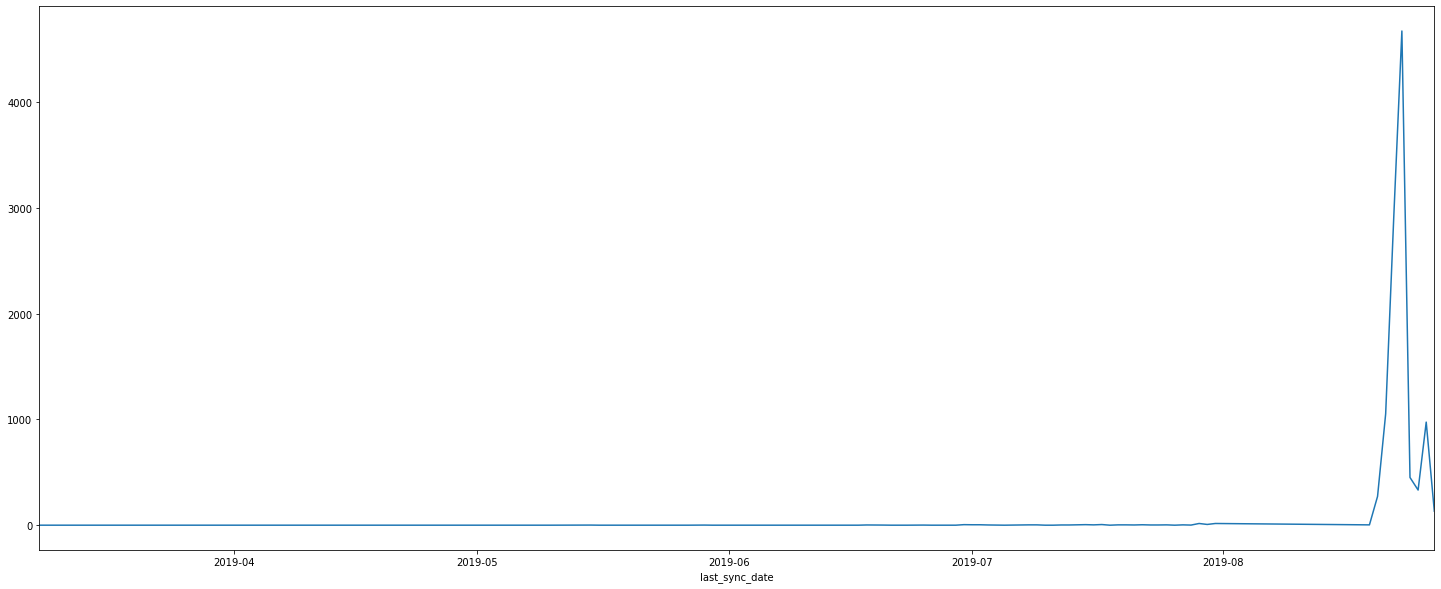

In [13]:
df_updated_skul=data_skul[data_skul.is_updated==1]
df_updated_skul['last_sync']=pd.to_datetime(df_updated_skul['last_sync'])
df_updated_skul['last_sync_date']=df_updated_skul.last_sync.apply(lambda x: x.date())
df_updated_skul.groupby('last_sync_date').size().plot(figsize=(25,10))

#### 3. SD, SMP, SMA Portion

In [14]:
count_bp=data_skul.groupby('bp').size()
pd.DataFrame({'skul_count':count_bp,'skul_pct':count_bp/count_bp.sum()}).sort_values('skul_count',ascending=False)

,skul_count,skul_pct
bp,,
SD,148310,0.679900
SMP,39482,0.180998
SMK,14049,0.064405
SMA,13606,0.062374
SLB,1902,0.008719
SPK SD,197,0.000903
SPK SMP,171,0.000784
SDLB,147,0.000674
SPK SMA,118,0.000541


In [15]:
count_bp=data_skul.groupby(['bp','status']).size()
pd.DataFrame({'skul_count':count_bp,'skul_pct':count_bp/count_bp.sum()})

skul_count  skul_pct
bp      status                      
SD      Negeri      131267  0.601770
        Swasta       17043  0.078131
SDLB    Negeri          43  0.000197
        Swasta         104  0.000477
SLB     Negeri         513  0.002352
        Swasta        1389  0.006368
SMA     Negeri        6750  0.030944
        Swasta        6856  0.031430
SMK     Negeri        3537  0.016215
        Swasta       10512  0.048190
SMLB    Negeri           8  0.000037
        Swasta          57  0.000261
SMP     Negeri       23089  0.105847
        Swasta       16393  0.075151
SMPLB   Negeri           8  0.000037
        Swasta          80  0.000367
SPK SD  Swasta         197  0.000903
SPK SMA Negeri           1  0.000005
        Swasta         117  0.000536
SPK SMP Negeri           1  0.000005
        Swasta         170  0.000779

In [16]:
dprov_cnt_all=[]
for prov in data_skul.provinsi.unique():
    dprov=data_skul[(data_skul.provinsi==prov)&(data_skul.bp!='SD')]
    dprov_cnt=dprov.groupby('bp').size()
    dprov_cnt=pd.DataFrame({'skul_cnt':dprov_cnt,'skul_pct':dprov_cnt/dprov_cnt.sum()}).reset_index()
    dprov_cnt['provinsi']=prov
    dprov_cnt_all.append(dprov_cnt)
dprov_cnt_all=pd.concat(dprov_cnt_all)

In [17]:
dprov_bp_pct=dprov_cnt_all.groupby(['provinsi','bp']).mean().unstack()['skul_pct'].fillna(0.0)

In [18]:
matplotlib.rcParams.update({'font.size': 13})

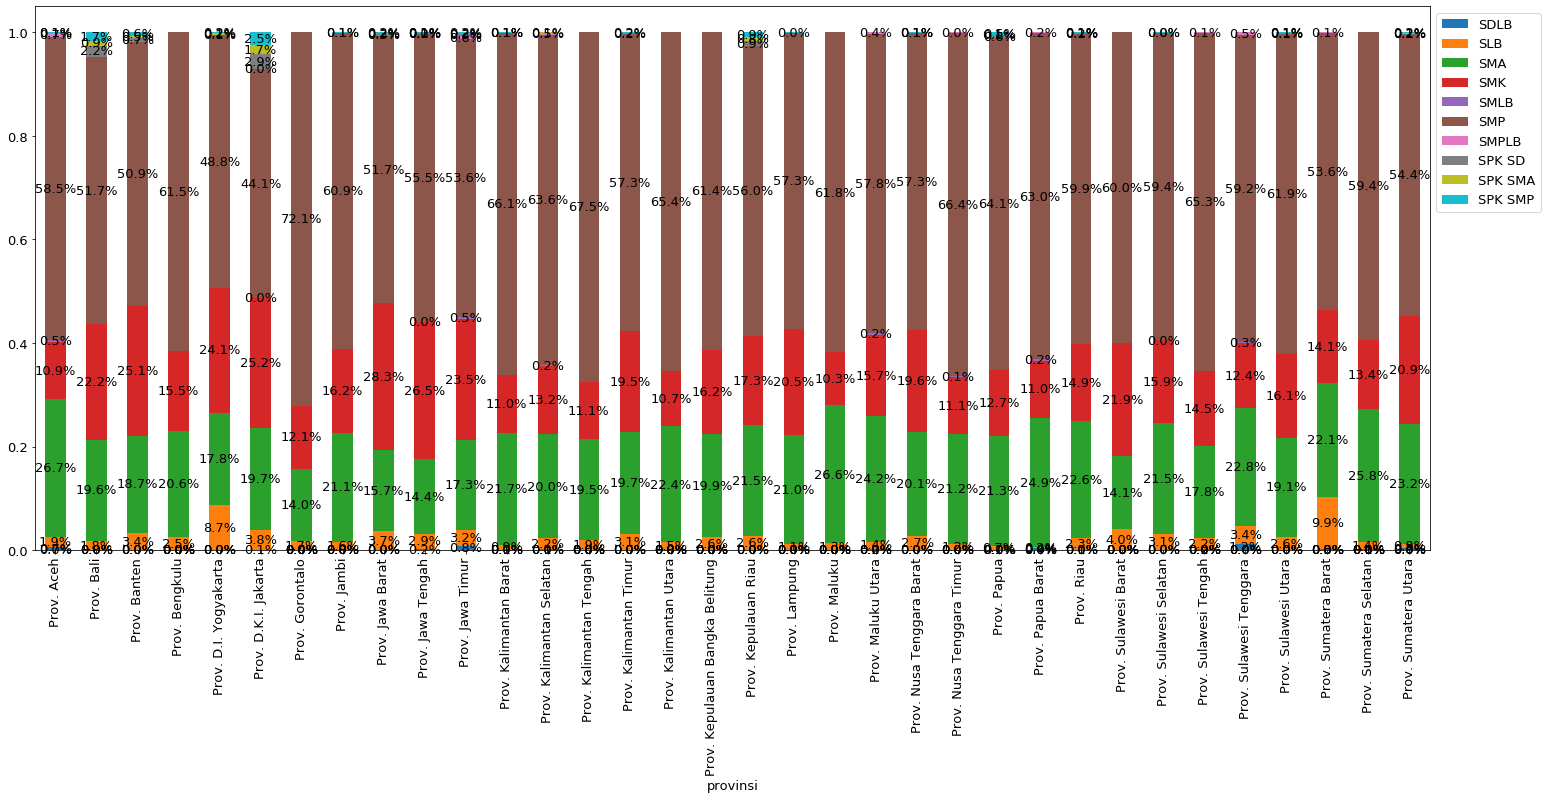

In [19]:
# dprov_bp_pct
ax=dprov_bp_pct.plot(kind='bar', stacked=True, figsize=(25,10))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height*100), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.legend(bbox_to_anchor=(1, 1))


#### 4.School Numbers

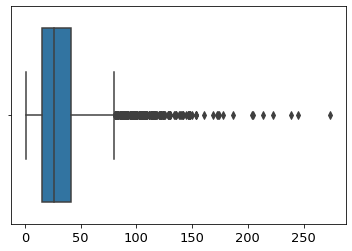

In [20]:
sns.boxplot(data_skul.groupby(['provinsi','kecamatan']).size())

In [21]:
df_kec_skul_cnt=data_skul.groupby(['provinsi','kecamatan']).size().reset_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

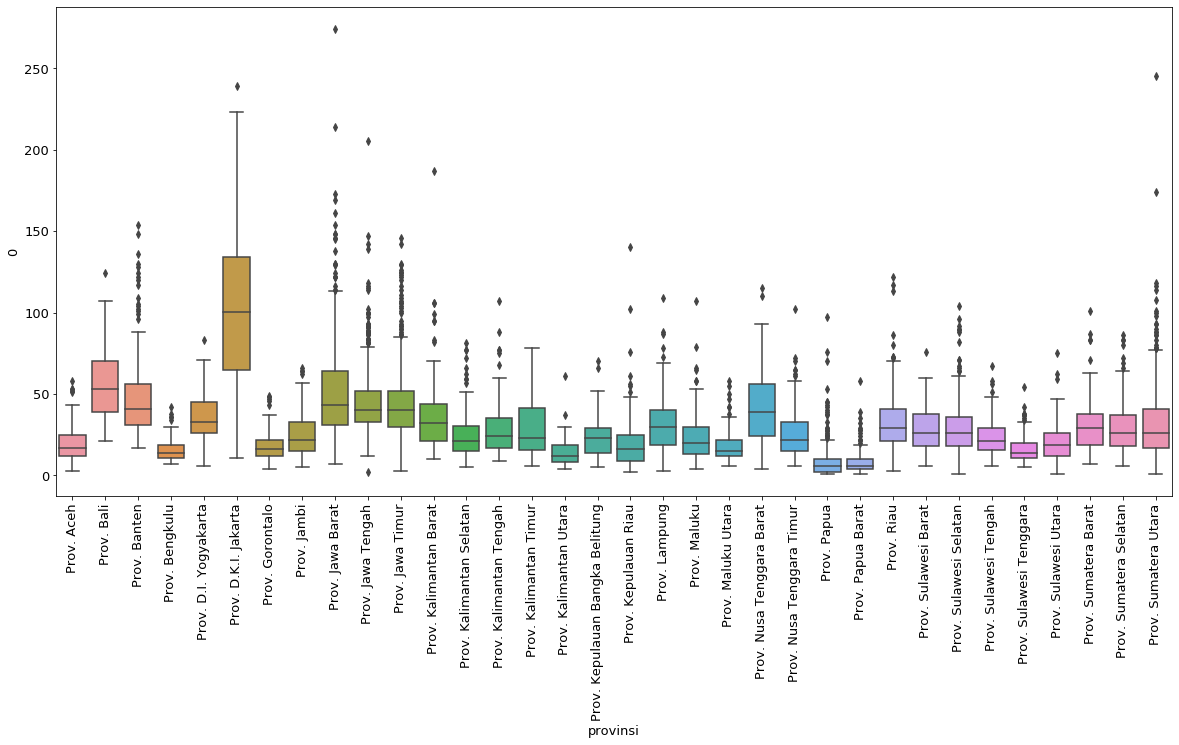

In [22]:
plt.figure(figsize=(20,9))
sns.boxplot(x='provinsi',y=0,data=df_kec_skul_cnt)
plt.xticks(rotation=90)

In [23]:
df_kec_skul_cnt[df_kec_skul_cnt[0]>200]

,provinsi,kecamatan,0
701,Prov. D.K.I. Jakarta,Kec. Cengkareng,239
706,Prov. D.K.I. Jakarta,Kec. Duren Sawit,204
712,Prov. D.K.I. Jakarta,Kec. Kali Deres,223
1060,Prov. Jawa Barat,Kec. Cibinong,274
1502,Prov. Jawa Barat,Kec. Tambun Selatan,214
1744,Prov. Jawa Tengah,Kec. Karanganyar,205
6750,Prov. Sumatera Utara,Kec. Percut Sei Tuan,245


In [24]:
XX=df_kec_skul_cnt.groupby('provinsi')[0].std()
XX.sort_values(ascending=False)

provinsi
Prov. D.K.I. Jakarta               50.712654
Prov. Jawa Barat                   30.072940
Prov. Banten                       27.980347
Prov. Sumatera Utara               23.749879
Prov. Kepulauan Riau               22.798101
Prov. Bali                         22.511860
Prov. Nusa Tenggara Barat          22.424422
Prov. Kalimantan Barat             22.330759
Prov. Jawa Timur                   21.485323
Prov. Jawa Tengah                  20.769922
Prov. Riau                         19.513639
Prov. Kalimantan Timur             17.655992
Prov. Sulawesi Selatan             16.611200
Prov. Kalimantan Tengah            16.495910
Prov. Maluku                       16.286719
Prov. Lampung                      16.205734
Prov. Sumatera Selatan             15.749732
Prov. Sumatera Barat               15.723639
Prov. D.I. Yogyakarta              14.827638
Prov. Kalimantan Selatan           14.540755
Prov. Kepulauan Bangka Belitung    14.185079
Prov. Nusa Tenggara Timur          13.704736
P

## Mapping

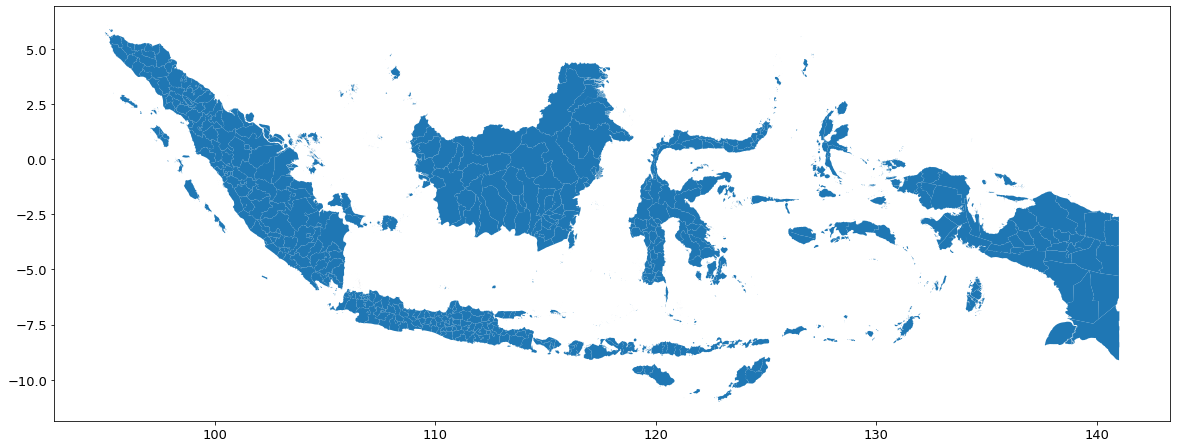

In [25]:
map_df.plot(figsize=(20,10))

#### Example Map Point

In [26]:
def create_points_column(df):
    y=df['lintang']
    x=df['bujur']
    return Point(x,y)

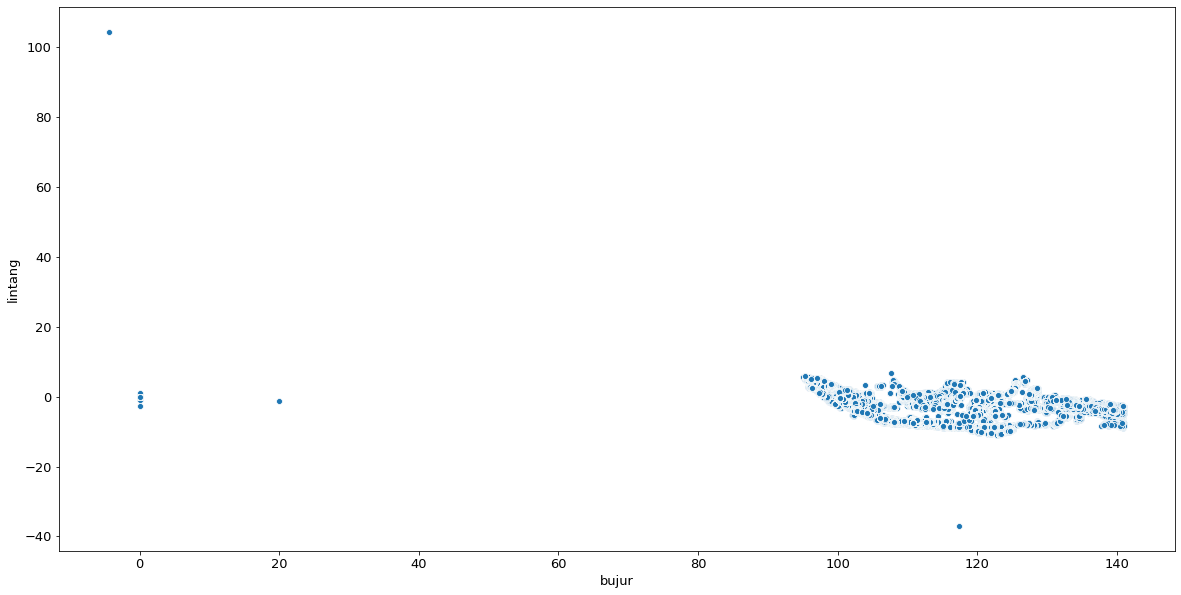

In [27]:
# data_interim2
plt.figure(figsize=(20,10))
sns.scatterplot(x='bujur',y='lintang',data=data_skul)

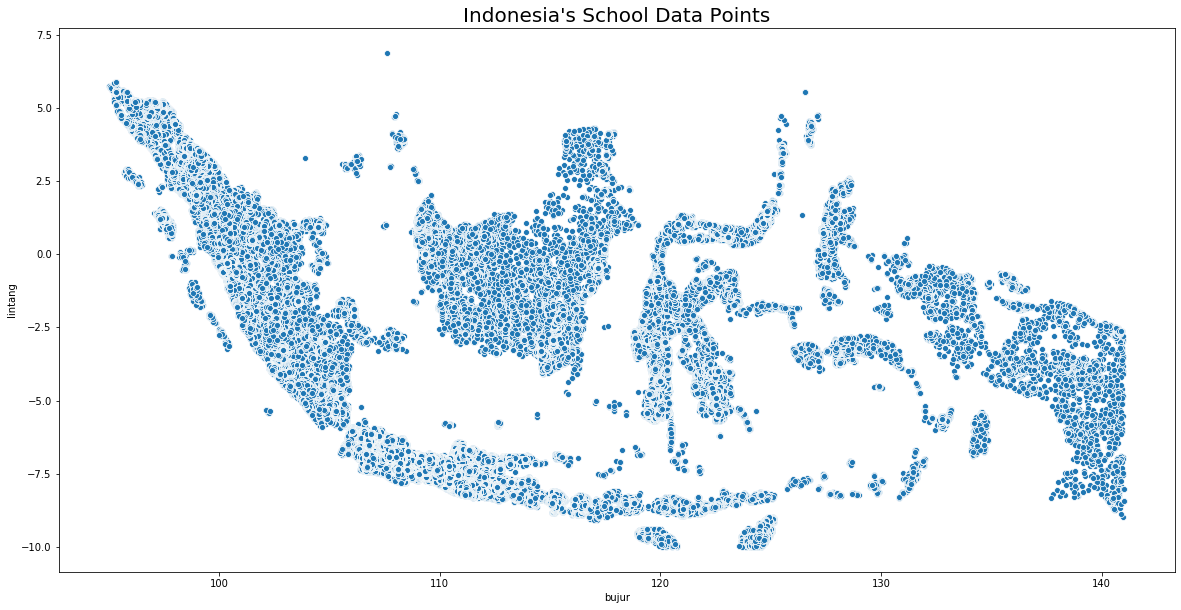

In [474]:
data_skul['outlier_point']=np.where((data_skul.lintang>20)|(data_skul.lintang<-10)|(data_skul.bujur<80),1,0)
# data_interim2
plt.figure(figsize=(20,10))
plt.title("Indonesia's School Data Points",{'fontsize':20})
sns.scatterplot(x='bujur',y='lintang',data=data_skul[data_skul.outlier_point==0])

In [29]:
# len(data_skul.kab_kota.unique())

In [30]:
data_merge_map=pd.merge(data_skul,map_reference[['kab_kota','NAME_2']],on='kab_kota',how='left')
data_merge_map=pd.merge(data_merge_map,map_df[['NAME_2','NAME_1','geometry']],on='NAME_2',how='left')
data_merge_map['Point']=data_merge_map.apply(create_points_column,axis=1)

In [31]:
# XX=data_merge_map[data_merge_map.NAME_2=='Jakarta Barat']['Point'].values
# XX=gpd.GeoDataFrame({'geometry':XX})
# XX.within(map_df[map_df.NAME_2=='Jakarta Barat'].geometry.values[0])

In [32]:
data_merge_map.bp.unique()

array(['SD', 'SMP', 'SMA', 'SMK', 'SDLB', 'SMPLB', 'SMLB', 'SLB',
       'SPK SD', 'SPK SMP', 'SPK SMA'], dtype=object)

In [33]:
# data_merge_map.bp.str.lower().str.contains

In [34]:
def get_school_map(kab_kot_name,lvl='all'):
    outlier=False
    split=True
    map_data=map_df.copy()
    source_data=data_merge_map.copy()
    
    if outlier:
        pass
    else:
        source_data=source_data[source_data['outlier_point']==0]
    
    data_point_example=source_data[source_data.NAME_2==kab_kot_name]
    crs={'init':'epsg:4326'}
    
    fig,ax=plt.subplots(figsize=(12,12))
    map_data[map_data.NAME_2==kab_kot_name].plot(ax=ax,alpha=0.4,color='grey')
    
    if split:
        if lvl=='all':
            for jenjang,lbl in zip(['sd','smp','sma','smk'],[('red','SD'),('blue','SMP'),('green','SMA'),('black','SMK')]):
                data_point_jenjang=data_point_example[data_point_example.bp.str.lower().str.contains(jenjang)]
                # geom=[Point(xy) for xy in zip(data_point_jenjang['bujur'],data_point_jenjang['lintang'])]
                geom=data_point_jenjang['Point']
                geo_data_point=gpd.GeoDataFrame(data_point_jenjang,crs=crs,geometry=geom)
                geo_data_point.plot(ax=ax,markersize=20,color=lbl[0],label=lbl[1])
        elif lvl=='sd':
            data_point_jenjang=data_point_example[data_point_example.bp.str.lower().str.contains(lvl)]
            # geom=[Point(xy) for xy in zip(data_point_jenjang['bujur'],data_point_jenjang['lintang'])]
            geom=data_point_jenjang['Point']
            geo_data_point=gpd.GeoDataFrame(data_point_jenjang,crs=crs,geometry=geom)
            geo_data_point.plot(ax=ax,markersize=20,color='red',label='SD')
        elif lvl=='smp':
            data_point_jenjang=data_point_example[data_point_example.bp.str.lower().str.contains(lvl)]
            # geom=[Point(xy) for xy in zip(data_point_jenjang['bujur'],data_point_jenjang['lintang'])]
            geom=data_point_jenjang['Point']
            geo_data_point=gpd.GeoDataFrame(data_point_jenjang,crs=crs,geometry=geom)
            geo_data_point.plot(ax=ax,markersize=20,color='blue',label='SMP')
        elif lvl=='sma':
            data_point_jenjang=data_point_example[data_point_example.bp.str.lower().str.contains(lvl)]
            # geom=[Point(xy) for xy in zip(data_point_jenjang['bujur'],data_point_jenjang['lintang'])]
            geom=data_point_jenjang['Point']
            geo_data_point=gpd.GeoDataFrame(data_point_jenjang,crs=crs,geometry=geom)
            geo_data_point.plot(ax=ax,markersize=20,color='green',label='SMA')
        elif lvl=='smk':
            data_point_jenjang=data_point_example[data_point_example.bp.str.lower().str.contains(lvl)]
            # geom=[Point(xy) for xy in zip(data_point_jenjang['bujur'],data_point_jenjang['lintang'])]
            geom=data_point_jenjang['Point']
            geo_data_point=gpd.GeoDataFrame(data_point_jenjang,crs=crs,geometry=geom)
            geo_data_point.plot(ax=ax,markersize=20,color='black',label='SMK')
        
    else:
        # geom=[Point(xy) for xy in zip(data_point_example['bujur'],data_point_example['lintang'])]
        geom=data_point_example['Point']
        geo_data_point=gpd.GeoDataFrame(data_point_example,crs=crs,geometry=geom)
        geo_data_point.plot(ax=ax,markersize=20,color='red',label='school')
    
    plt.legend(prop={'size':15})
    plt.title(kab_kot_name)
    return plt.show()

In [35]:
dropdown_kab_kot = widgets.Dropdown(options=map_df.NAME_2.sort_values().unique())
interact(get_school_map,kab_kot_name=dropdown_kab_kot,lvl=['all','sd','smp','sma','smk']);

interactive(children=(Dropdown(description='kab_kot_name', options=('Aceh Barat', 'Aceh Barat Daya', 'Aceh Bes…

#### Example Radius

In [36]:
# http://www.longitudestore.com/how-big-is-one-gps-degree.html
def deg_distance(deg):
    # 1 degree in equator
#     x=1*np.sin(deg)*111.32
#     y=1*np.cos(deg)*110.57
    
    # 1 minute in equator
    x=1*np.sin(deg)*1.84
    y=1*np.cos(deg)*1.86
    
    # 1 second in equator
#     x=1*np.sin(deg)*30.72
#     y=1*np.cos(deg)*30.92
    return np.sqrt((x**2)+(y**2))

def dec_to_dms(buff):
    Deg=np.floor(buff)
    buff0=buff-Deg
    base_min=(1/60)
    Minu=0
    while buff0>base_min:
        buff0=buff0-base_min
        Minu+=1
    Sec=buff0*3600
    return Deg,Minu,Sec

def radius_to_km(buff):
    x,y,z=dec_to_dms(buff)
    distance=(x*110.93899)+(y*1.85018)+(z*0.030821)
    return distance

In [37]:
proj_wgs84 = pyproj.Proj(init='epsg:4326')


def geodesic_point_buffer(points, km):
    # Azimuthal equidistant projection
    x,y=points.coords[0]
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=x, lon=y)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]



def get_school_map_radius(kab_name,buff):
    outlier=False
    map_data=map_df.copy()
    source_data=data_merge_map.copy()
    
    if outlier:
        pass
    else:
        source_data=source_data[source_data['outlier_point']==0]
    
    data_point_example=source_data[source_data.NAME_2==kab_name]
    data_point_example=data_point_example.dropna()
#     crs={'init':'epsg:4326'}
    crs={'init': 'epsg:3174'}
    
    fig,ax=plt.subplots(figsize=(12,12))
    map_data[map_data.NAME_2==kab_name].plot(ax=ax,alpha=0.4,color='grey')

    # geom=[Point(xy) for xy in zip(data_point_example['bujur'],data_point_example['lintang'])]
    geom=data_point_example['Point']
    pts=GeoSeries(geom)
    ## buff in KM
    circles = pts.buffer(buff)
    distan=str(radius_to_km(buff))
    plt.title('School Radius '+distan[:4]+' KM')
    return circles.plot(ax=ax,alpha=0.4,color='black')

In [38]:
dropdown_kab = widgets.Dropdown(options=map_df.NAME_2.sort_values().unique())
floatslide_buff= widgets.FloatSlider(
                value=0.002,
                min=0.001,
                max=0.0900849,
                step=0.001,
#                 description='Test:',
#                 disabled=False,
#                 continuous_update=False,
#                 orientation='horizontal',
#                 readout=True,
#                 readout_format='.1f',
            )
interact(get_school_map_radius,kab_name=dropdown_kab,buff=floatslide_buff);

interactive(children=(Dropdown(description='kab_name', options=('Aceh Barat', 'Aceh Barat Daya', 'Aceh Besar',…

    0.002 ~ 217 Meters
    0.004 ~ 434 Meters
    0.008 ~ 931 Meters
    0.016 ~ 1829 Meters ~ 1.8 KM
    0.026666 ~ 2.95 KM
    0.0444444 ~ 4.92 KM
    0.071111111 ~ 7.856 KM

In [39]:
radius_to_km(0.002)

0.2219112

#### Example of heatmap

In [40]:
# map_df

In [41]:
school_cnt=data_merge_map[data_merge_map.outlier_point==0].groupby(['NAME_2']).size().reset_index()
school_cnt_map=pd.merge(map_df,school_cnt,how='left',on='NAME_2')

In [42]:
school_cnt_map[school_cnt_map[0].isnull()==True]

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,0
59,IDN,Indonesia,IDN.6_1,Gorontalo,None,IDN.6.3_1,Danau Limboto,None,None,Kabupaten,Regency,7502,ID.GO.GO,"POLYGON ((123.01784515 0.56959265, 123.0177536...",NaN
107,IDN,Indonesia,IDN.9_1,Jawa Barat,None,IDN.9.27_1,Waduk Cirata,None,None,Water Body,Water Body,3288,None,"POLYGON ((107.28666687 -6.78579998, 107.286529...",NaN
141,IDN,Indonesia,IDN.10_1,Jawa Tengah,None,IDN.10.34_1,Waduk Kedungombo,None,None,Water Body,Water Body,3388,None,"(POLYGON ((110.83525848 -7.30740309, 110.83543...",NaN
190,IDN,Indonesia,IDN.12_1,Kalimantan Barat,None,IDN.12.9_1,Pontianak,None,None,Kabupaten,Regency,6104,ID.KB.PR,"(POLYGON ((108.85961151 0.51084, 108.85968781 ...",NaN
292,IDN,Indonesia,IDN.21_1,Nusa Tenggara Timur,None,IDN.21.5_1,Kota Kupang,None,None,Kota,City,5371,ID.NT.KM,"POLYGON ((123.58547974 -10.28884983, 123.58477...",NaN
300,IDN,Indonesia,IDN.21_1,Nusa Tenggara Timur,None,IDN.21.13_1,Rote Ndao,None,None,Kabupaten,Regency,5314,ID.NT.RN,"(POLYGON ((122.87141418 -10.96884727, 122.8731...",NaN
301,IDN,Indonesia,IDN.21_1,Nusa Tenggara Timur,None,IDN.21.14_1,Sabu Raijua,None,None,Kabupaten,Regency,5320,ID.NT.SJ,"(POLYGON ((121.27793121 -10.82205391, 121.2793...",NaN
364,IDN,Indonesia,IDN.25_1,Sulawesi Barat,None,IDN.25.3_1,Mamuju Utara,None,None,Kabupaten,Regency,7605,ID.SR.MU,"POLYGON ((119.34526062 -1.79376125, 119.345153...",NaN
394,IDN,Indonesia,IDN.27_1,Sulawesi Tengah,None,IDN.27.5_1,Morowali,None,None,Kabupaten,Regency,7203,ID.ST.MO,"(POLYGON ((123.04191589 -3.54919505, 123.04098...",NaN
403,IDN,Indonesia,IDN.28_1,Sulawesi Tenggara,None,IDN.28.4_1,Buton,None,None,Kabupaten,Regency,7401,ID.SG.BN,"(POLYGON ((122.73675537 -6.21320581, 122.73654...",NaN


In [43]:
school_cnt_map2=school_cnt_map[school_cnt_map[0].isnull()==False]

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


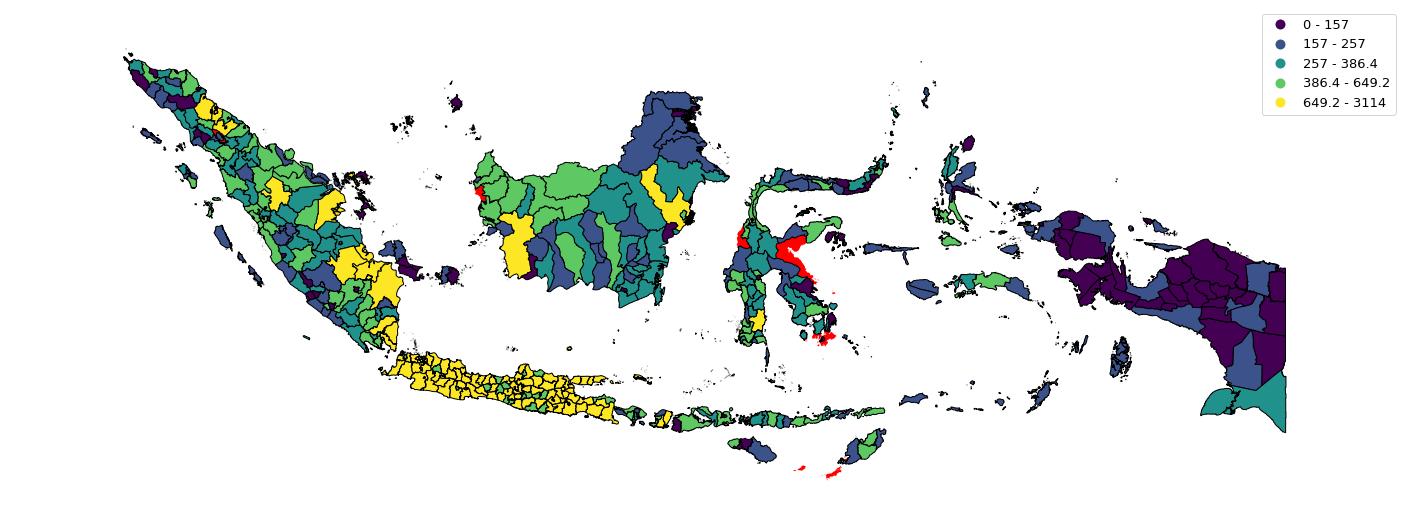

In [44]:
ax=geoplot.choropleth(
    school_cnt_map2, hue=school_cnt_map2[0], figsize=(25,15), legend=True
)

school_cnt_map[school_cnt_map[0].isnull()==True].plot(ax=ax, color='red')

## Questions

#### The Dense

Choose the most dense cities to reduce the Population Variable effect. Get the name of `NAME_2` or `Kab_Kota` which associate with the cities

    * DKI Jakarta --> 'Jakarta Utara', 'Jakarta Timur',
       'Jakarta Selatan', 'Jakarta Pusat', 'Jakarta Barat'
       
    * Kota Surabaya --> 'Surabaya'
    * Kota Medan --> 'Kota Medan'
    * Kota Bandung --> 'Kota Bandung', 'Bandung', 'Bandung Barat'
    * Kota Makassar --> 'Makassar'
    * Kota Palembang --> 'Palembang'

In [45]:
data_merge_map.head()

,provinsi,kab_kota,kecamatan,nama_sekolah,npsn,bp,status,last_sync,jml_sync,pd,...,url_sekolah,coordinate,lintang,bujur,is_updated,outlier_point,NAME_2,NAME_1,geometry,Point
0,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD N SEUNEUBOK TEUNGOH,10107900,SD,Negeri,-,0,0.0,...,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3594000,Bujur : 95.9281000",4.3594,95.9281,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9281 4.3594)
1,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE BATEE,10110676,SD,Negeri,-,0,0.0,...,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3453000,Bujur : 95.9736000",4.3453,95.9736,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9736 4.3453)
2,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE SUNDAK,10110270,SD,Negeri,-,0,0.0,...,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3257000,Bujur : 95.9761000",4.3257,95.9761,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9761 4.3257)
3,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ARONGAN WOYLA,10107859,SD,Negeri,-,0,0.0,...,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.2994000,Bujur : 95.9536000",4.2994,95.9536,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.95359999999999 4.2994)
4,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI COT BULOH,10107863,SD,Negeri,-,0,0.0,...,http://dapo.dikdasmen.kemdikbud.go.id/sekolah/...,"Lintang : 4.3252000,Bujur : 95.9576000",4.3252,95.9576,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9576 4.3252)


In [46]:
# data_merge_map[data_merge_map.provinsi.str.lower().str.contains('sumatera selatan')].NAME_2.unique()

In [47]:
chosen_area=['Jakarta Utara', 'Jakarta Timur','Jakarta Selatan', 'Jakarta Pusat'
             ,'Jakarta Barat','Surabaya','Kota Medan','Kota Bandung', 'Bandung', 'Bandung Barat','Makassar','Palembang']

#### Get The Random Points

In [476]:
# https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python
def random_points_in_polygon(number, polygon):
    import random
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if (polygon.contains(point))&(point not in points):
            points.append(point)
            i += 1
    return points

def random_points_in_area(number,area_name):
    polyg=map_df[map_df.NAME_2==area_name].geometry.values[0]
    points=random_points_in_polygon(number, polyg)
    return points

def plot_map_and_point(geom_points,kab_name):
    map_data=map_df.copy()
    crs={'init': 'epsg:3174'}
    
    fig,ax=plt.subplots(figsize=(12,12))
    map_data[map_data.NAME_2==kab_name].plot(ax=ax,alpha=0.4,color='grey')
    pts=GeoSeries(geom_points)
    ## buff in KM
    pts.plot(ax=ax,alpha=0.4,color='black')  
    plt.title(kab_name)
    return plt.legend(prop={'size':15})

No handles with labels found to put in legend.


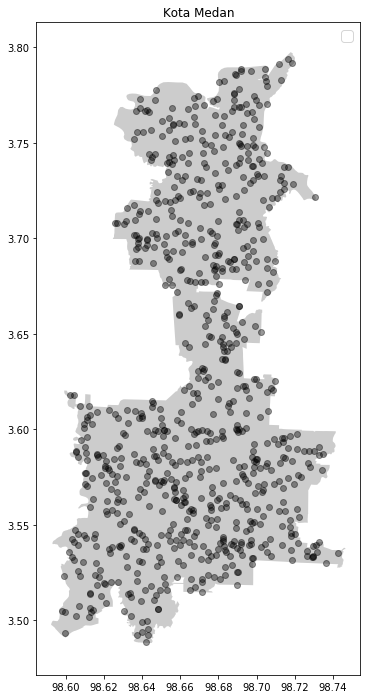

In [477]:
## Example
city_p='Kota Medan'
pp=random_points_in_area(800,city_p)
plot_map_and_point(pp,city_p)

#### Do Analysis on Student Centric
If the Zoning system is done by restricting the future student to choose school only within certain radius from their house.

In [478]:
## Pick Medan as example

In [479]:
city_p='Surabaya'
pp=random_points_in_area(3000,city_p)
geo_pp=GeoSeries(pp)
data_skul_p=data_merge_map[(data_merge_map.NAME_2==city_p)&(data_merge_map.outlier_point==0)]

## flagging outside the polygon
XX=data_skul_p['Point'].values
XX=gpd.GeoDataFrame({'geometry':XX})
data_skul_p['inside_polyg']=XX.within(map_df[map_df.NAME_2==city_p].geometry.values[0]).values
data_skul_p['inside_polyg']=data_skul_p['inside_polyg'].astype(int)

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


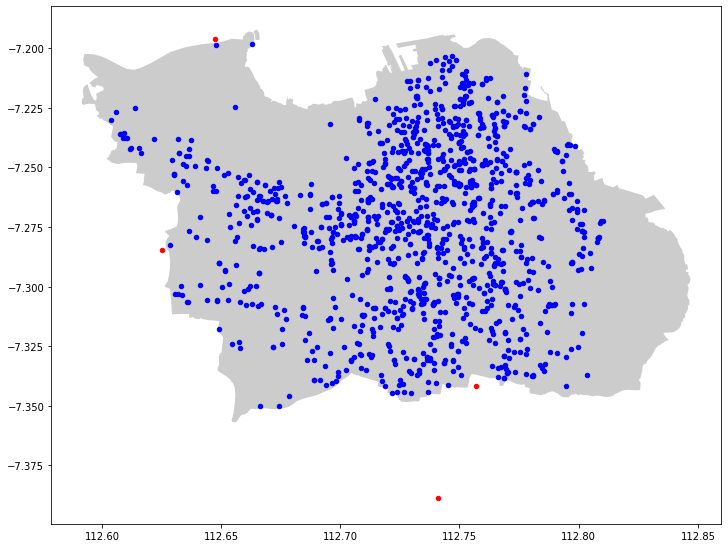

In [480]:
## Mapping outside the polygon
crs={'init':'epsg:4326'}
fig,ax=plt.subplots(figsize=(12,12))
map_df[map_df.NAME_2==city_p].plot(ax=ax,alpha=0.4,color='grey')

geom1=data_skul_p[data_skul_p.inside_polyg==1]['Point']
geo_data_point=gpd.GeoDataFrame(data_skul_p[data_skul_p.inside_polyg==1],crs=crs,geometry=geom1)
geo_data_point.plot(ax=ax,markersize=20,color='blue',label='Inside')

geom0=data_skul_p[data_skul_p.inside_polyg==0]['Point']
geo_data_point=gpd.GeoDataFrame(data_skul_p[data_skul_p.inside_polyg==0],crs=crs,geometry=geom0)
geo_data_point.plot(ax=ax,markersize=20,color='red',label='Outside')
        
plt.show()

In [66]:
data_skul_p[data_skul_p.bp.str.lower().str.contains('sma')].inside_polyg.mean()

0.9444444444444444

In [67]:
# data_skul_p[data_skul_p.bp.str.lower().str.contains('sma')].bp.unique()

In [68]:
## Filter out all the school which outside polygon and not SMA
data_skul_p2=data_skul_p[(data_skul_p.bp.str.lower().str.contains('sma'))&(data_skul_p.inside_polyg==1)]

In [69]:
len(data_skul_p2)

204

In [70]:
# ## Mapping all SMA after filter out
# crs={'init':'epsg:4326'}
# fig,ax=plt.subplots(figsize=(12,12))
# map_df[map_df.NAME_2==city_p].plot(ax=ax,alpha=0.4,color='grey')

# geom1=data_skul_p2['Point']
# geo_data_point=gpd.GeoDataFrame(data_skul_p2,crs=crs,geometry=geom1)
# geo_data_point.plot(ax=ax,markersize=20,color='blue',label='SMA')
        
# plt.show()

In [71]:
radius_to_km(0.117109)

13.000339360400002

In [72]:
0.00181*2.2

0.003982

In [73]:
# radi=[0.2,0.5,1,2,5,8,10]
radi=[0.00181,0.00451,0.0091,0.0181,0.0451,0.0721,0.0901,0.117109]


In [74]:
## Check for every random point with certain radius
df_geo_pp=gpd.GeoDataFrame({'id':[i for i in range(len(geo_pp))]},geometry=geo_pp)

skul_cnt=[]
XX=data_skul_p2['Point'].values
XX=gpd.GeoDataFrame({'geometry':XX})
cir=geo_pp.buffer(radi[3])
for pol in cir:
    skul_cnt.append(XX.within(pol).values.sum())
df_geo_pp['school_cnt1']=skul_cnt

In [75]:
(df_geo_pp.school_cnt1>0).mean()

0.9583333333333334

In [76]:
df_geo_pp.school_cnt1.describe()

count    3000.000000
mean        7.928667
std         7.233926
min         0.000000
25%         2.000000
50%         5.000000
75%        12.000000
max        34.000000
Name: school_cnt1, dtype: float64

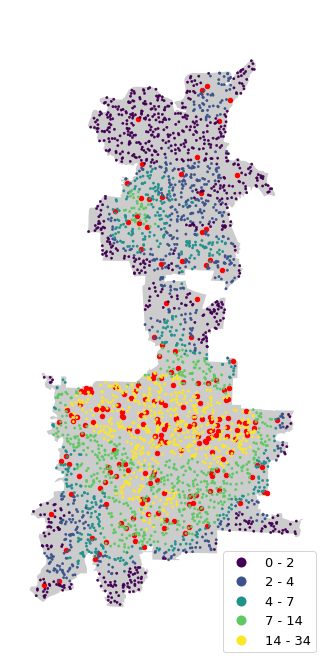

In [77]:
fig,ax=plt.subplots(figsize=(12,12))
map_df[map_df.NAME_2==city_p].plot(ax=ax,alpha=0.4,color='grey')

geom1=data_skul_p2['Point']
geo_data_point=gpd.GeoDataFrame(data_skul_p2,crs=crs,geometry=geom1)
geo_data_point.plot(ax=ax,markersize=20,color='red',label='SMA')


geoplot.pointplot(
    df_geo_pp,
    hue='school_cnt1',
    legend=True, linewidth=0.5, ax=ax
)

plt.tilte=city_p

In [149]:
# Pick Surabaya as example

In [150]:
# radi=[0.2,0.5,1,2,5,8,10,13,15]
radi=[0.00181,0.00451,0.0091,0.0181,0.0451,0.0721,0.0901,0.117109]

city_p='Surabaya'
pp=random_points_in_area(3000,city_p)
geo_pp=GeoSeries(pp)
data_skul_p=data_merge_map[(data_merge_map.NAME_2==city_p)&(data_merge_map.outlier_point==0)]

## flagging outside the polygon
XX=data_skul_p['Point'].values
XX=gpd.GeoDataFrame({'geometry':XX})
data_skul_p['inside_polyg']=XX.within(map_df[map_df.NAME_2==city_p].geometry.values[0]).values
data_skul_p['inside_polyg']=data_skul_p['inside_polyg'].astype(int)

## Filter out all the school which outside polygon and not SMA
data_skul_p2=data_skul_p[(data_skul_p.bp.str.lower().str.contains('sma'))&(data_skul_p.inside_polyg==1)]

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [151]:
data_skul_p[data_skul_p.bp.str.lower().str.contains('sma')].inside_polyg.mean()

0.993006993006993

In [152]:
len(data_skul_p2)

142

In [153]:
# data_skul_p2.status.value_counts()

In [154]:
## Check for every random point with certain radius
df_geo_pp=gpd.GeoDataFrame({'id':[i for i in range(len(geo_pp))]},geometry=geo_pp)

skul_cnt=[]
XX=data_skul_p2['Point'].values
XX=gpd.GeoDataFrame({'geometry':XX})
cir=geo_pp.buffer(radi[3])
for pol in cir:
    skul_cnt.append(XX.within(pol).values.sum())
df_geo_pp['school_cnt1']=skul_cnt

In [158]:
(df_geo_pp.school_cnt1>=3).mean()

0.624

In [156]:
df_geo_pp.school_cnt1.describe()

count    3000.000000
mean        5.215667
std         5.040201
min         0.000000
25%         1.000000
50%         4.000000
75%         8.000000
max        25.000000
Name: school_cnt1, dtype: float64

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


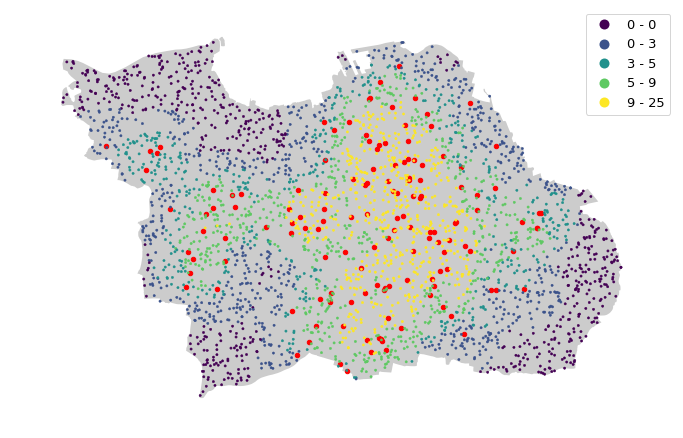

In [157]:
fig,ax=plt.subplots(figsize=(12,12))

map_df[map_df.NAME_2==city_p].plot(ax=ax,alpha=0.4,color='grey')

geom1=data_skul_p2['Point']
geo_data_point=gpd.GeoDataFrame(data_skul_p2,crs=crs,geometry=geom1)
geo_data_point.plot(ax=ax,markersize=20,color='red',label='SMA')


geoplot.pointplot(
    df_geo_pp,
    hue='school_cnt1',
    legend=True, linewidth=0.5, ax=ax
)

In [109]:
# Pick Makassar as example

In [110]:
# radi=[0.2,0.5,1,2,5,8,10,13,15]
radi=[0.00181,0.00451,0.0091,0.0181,0.0451,0.0721,0.0901,0.117109]

city_p='Makassar'
pp=random_points_in_area(3000,city_p)
geo_pp=GeoSeries(pp)
data_skul_p=data_merge_map[(data_merge_map.NAME_2==city_p)&(data_merge_map.outlier_point==0)]

## flagging outside the polygon
XX=data_skul_p['Point'].values
XX=gpd.GeoDataFrame({'geometry':XX})
data_skul_p['inside_polyg']=XX.within(map_df[map_df.NAME_2==city_p].geometry.values[0]).values
data_skul_p['inside_polyg']=data_skul_p['inside_polyg'].astype(int)

## Filter out all the school which outside polygon and not SMA
data_skul_p2=data_skul_p[(data_skul_p.bp.str.lower().str.contains('sma'))&(data_skul_p.inside_polyg==1)]

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [111]:
data_skul_p[data_skul_p.bp.str.lower().str.contains('sma')].inside_polyg.mean()

0.9921875

In [112]:
len(data_skul_p2)

127

In [113]:
# data_skul_p2.status.value_counts()

In [114]:
## Check for every random point with certain radius
df_geo_pp=gpd.GeoDataFrame({'id':[i for i in range(len(geo_pp))]},geometry=geo_pp)

skul_cnt=[]
XX=data_skul_p2['Point'].values
XX=gpd.GeoDataFrame({'geometry':XX})
cir=geo_pp.buffer(radi[3])
for pol in cir:
    skul_cnt.append(XX.within(pol).values.sum())
df_geo_pp['school_cnt1']=skul_cnt

In [115]:
(df_geo_pp.school_cnt1>0).mean()

0.872

In [116]:
df_geo_pp.school_cnt1.describe()

count    3000.000000
mean        7.437000
std         8.387062
min         0.000000
25%         2.000000
50%         4.000000
75%        11.000000
max        43.000000
Name: school_cnt1, dtype: float64

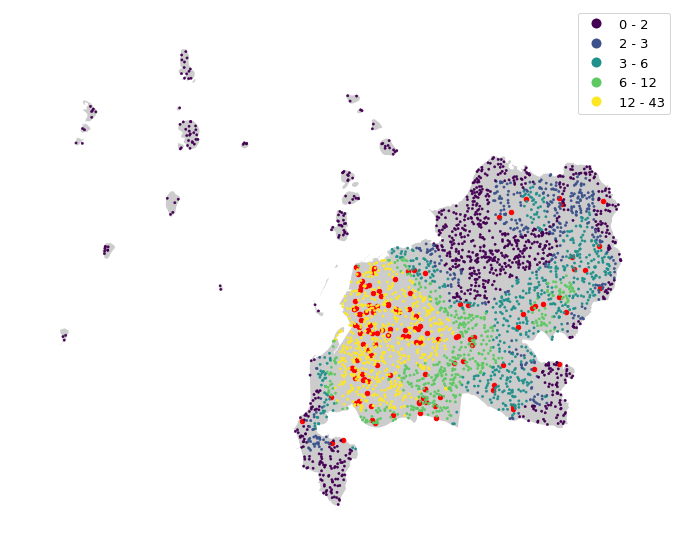

In [117]:
fig,ax=plt.subplots(figsize=(12,12))

map_df[map_df.NAME_2==city_p].plot(ax=ax,alpha=0.4,color='grey')

geom1=data_skul_p2['Point']
geo_data_point=gpd.GeoDataFrame(data_skul_p2,crs=crs,geometry=geom1)
geo_data_point.plot(ax=ax,markersize=20,color='red',label='SMA')


geoplot.pointplot(
    df_geo_pp,
    hue='school_cnt1',
    legend=True, linewidth=0.5, ax=ax
)

In [125]:
### Calculate for every dense cities
radi=[0.00181+(0.003982*i) for i in range(32)]
# radi=[radius_to_km(i) for i in radi]


df_geo_pp_r_list=[]
city_p='Surabaya'
for city_p in chosen_area:
    print('-'*15)
    print(city_p," starts")
    pp=random_points_in_area(2500,city_p)
    geo_pp=GeoSeries(pp)
    data_skul_p=data_merge_map[(data_merge_map.NAME_2==city_p)&(data_merge_map.outlier_point==0)]

    ## flagging outside the polygon
    XX=data_skul_p['Point'].values
    XX=gpd.GeoDataFrame({'geometry':XX})
    data_skul_p['inside_polyg']=XX.within(map_df[map_df.NAME_2==city_p].geometry.values[0]).values
    data_skul_p['inside_polyg']=data_skul_p['inside_polyg'].astype(int)

    ## Filter out all the school which outside polygon and not SMA
    data_skul_p2=data_skul_p[(data_skul_p.bp.str.lower().str.contains('sma'))&(data_skul_p.inside_polyg==1)]
    good_coord=data_skul_p[data_skul_p.bp.str.lower().str.contains('sma')].inside_polyg.mean()

    ## Check for every random point with certain radius
    df_geo_pp0=gpd.GeoDataFrame({'id':[i for i in range(len(geo_pp))]},geometry=geo_pp)

    XX=data_skul_p2['Point'].values
    XX=gpd.GeoDataFrame({'geometry':XX})

    df_geo_pp_list=[]
    for rr in radi:
        df_geo_pp=df_geo_pp0.copy()
        cir=geo_pp.buffer(rr)
        skul_cnt=[XX.within(pol).values.sum() for pol in cir]
            
        df_geo_pp['school_cnt1']=skul_cnt
        df_geo_pp['rads']=rr
        df_geo_pp_list.append(df_geo_pp)
    df_geo_pp_r=pd.concat(df_geo_pp_list)
    df_geo_pp_r['area']=city_p
    df_geo_pp_r['good_school_coord']=good_coord
    df_geo_pp_r_list.append(df_geo_pp_r)
    print(city_p," is done")
df_geo_chosen=pd.concat(df_geo_pp_r_list)

---------------
Jakarta Utara  starts


/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Jakarta Utara  is done
---------------
Jakarta Timur  starts
Jakarta Timur  is done
---------------
Jakarta Selatan  starts
Jakarta Selatan  is done
---------------
Jakarta Pusat  starts
Jakarta Pusat  is done
---------------
Jakarta Barat  starts
Jakarta Barat  is done
---------------
Surabaya  starts
Surabaya  is done
---------------
Kota Medan  starts
Kota Medan  is done
---------------
Kota Bandung  starts
Kota Bandung  is done
---------------
Bandung  starts
Bandung  is done
---------------
Bandung Barat  starts
Bandung Barat  is done
---------------
Makassar  starts
Makassar  is done
---------------
Palembang  starts
Palembang  is done


In [126]:
df_geo_chosen.head()

,id,geometry,school_cnt1,rads,area,good_school_coord
0,0,POINT (106.880685065056 -6.117914056116454),0,0.00181,Jakarta Utara,0.977778
1,1,POINT (106.9415140719673 -6.135259417361981),0,0.00181,Jakarta Utara,0.977778
2,2,POINT (106.8442993782174 -6.15233186498118),0,0.00181,Jakarta Utara,0.977778
3,3,POINT (106.9113820655668 -6.174903748242306),0,0.00181,Jakarta Utara,0.977778
4,4,POINT (106.8526396896716 -6.127379517137261),0,0.00181,Jakarta Utara,0.977778


In [129]:
df_geo_chosen['rad_in_km']=df_geo_chosen.rads.apply(radius_to_km)

In [130]:
df_geo_chosen.head()

,id,geometry,school_cnt1,rads,area,good_school_coord,rad_in_km
0,0,POINT (106.880685065056 -6.117914056116454),0,0.00181,Jakarta Utara,0.977778,0.20083
1,1,POINT (106.9415140719673 -6.135259417361981),0,0.00181,Jakarta Utara,0.977778,0.20083
2,2,POINT (106.8442993782174 -6.15233186498118),0,0.00181,Jakarta Utara,0.977778,0.20083
3,3,POINT (106.9113820655668 -6.174903748242306),0,0.00181,Jakarta Utara,0.977778,0.20083
4,4,POINT (106.8526396896716 -6.127379517137261),0,0.00181,Jakarta Utara,0.977778,0.20083


In [132]:
df_geo_chosen['more_than_3']=(df_geo_chosen.school_cnt1>=3).astype(int)

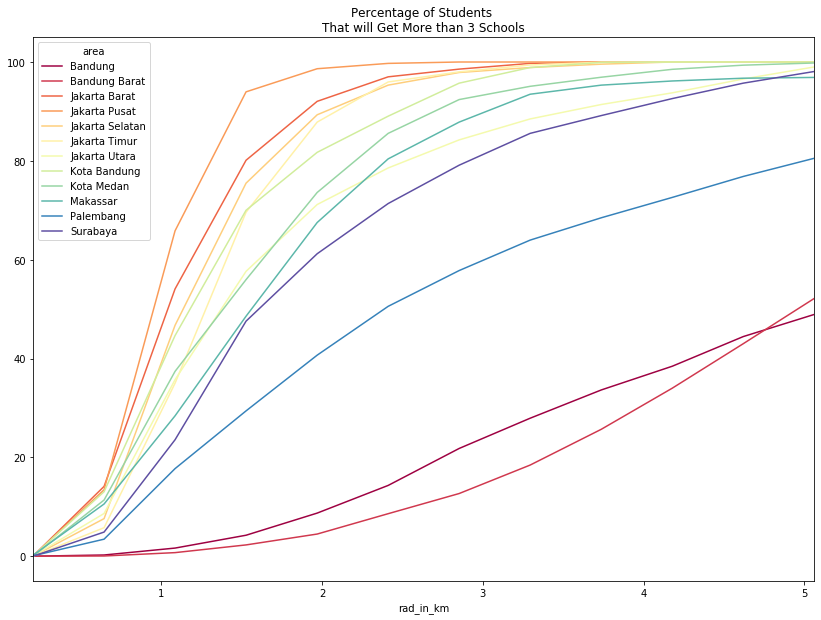

In [495]:
(df_geo_chosen[df_geo_chosen.rad_in_km<=5.1].groupby(['rad_in_km','area']).more_than_3.mean()*100).unstack().plot(figsize=(14,10)
                                ,title = "Percentage of Students \nThat will Get More than 3 Schools",cmap='Spectral')

In [547]:
df_geo_chosen['rad_in_km2']=(df_geo_chosen.rad_in_km*100).astype(int)*0.01

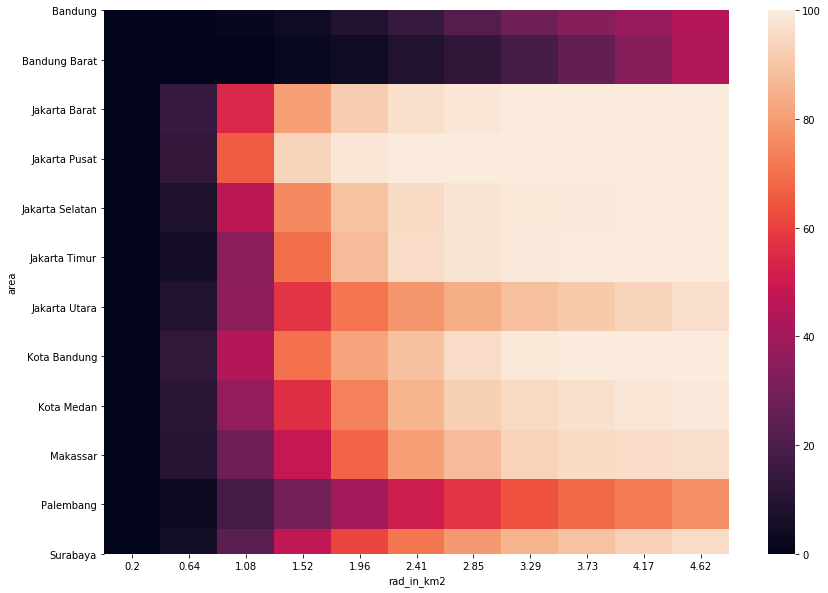

In [555]:
plt.figure(figsize=(14,10))
sns.heatmap((df_geo_chosen[df_geo_chosen.rad_in_km<=5].groupby(['rad_in_km2','area']).more_than_3.mean()*100).unstack().transpose())

In [49]:
def geom_transform(x):
    x,y=x.split('POINT')[-1].strip()[1:-1].split()
    x,y=float(x),float(y)
    return Point(x,y)

#### Get the map radius data

In [481]:
# df_geo_chosen.to_csv(PATH_INTERIM+'20191107_radius_data.csv',index=False)

df_geo_chosen=pd.read_csv(PATH_INTERIM+'20191107_radius_data.csv')
df_geo_chosen['geometry']=df_geo_chosen['geometry'].apply(geom_transform)
df_geo_chosen=gpd.GeoDataFrame(df_geo_chosen,geometry=df_geo_chosen['geometry'])

In [68]:
df_geo_chosen.head()

,id,geometry,school_cnt1,rads,area,good_school_coord,rad_in_km,more_than_3
0,0,POINT (106.880685065056 -6.117914056116454),0,0.00181,Jakarta Utara,0.977778,0.20083,0
1,1,POINT (106.9415140719673 -6.135259417361981),0,0.00181,Jakarta Utara,0.977778,0.20083,0
2,2,POINT (106.8442993782174 -6.15233186498118),0,0.00181,Jakarta Utara,0.977778,0.20083,0
3,3,POINT (106.9113820655668 -6.174903748242306),0,0.00181,Jakarta Utara,0.977778,0.20083,0
4,4,POINT (106.8526396896716 -6.127379517137261),0,0.00181,Jakarta Utara,0.977778,0.20083,0


In [69]:
## looping the inside polygon
data_merge_map2=[]
for city_pp in data_merge_map.NAME_2.dropna().unique():
    data_skul_p=data_merge_map[(data_merge_map.NAME_2==city_pp)]
    XX=data_skul_p['Point'].values
    XX=gpd.GeoDataFrame({'geometry':XX})
    try:
        data_skul_p['inside_polyg']=XX.within(map_df[map_df.NAME_2==city_pp].geometry.values[0]).values
    except:
        print(city_pp)
        data_skul_p['inside_polyg']=XX.within(map_df[map_df.NAME_2==city_pp].geometry.values[0]).values
    data_skul_p['inside_polyg']=data_skul_p['inside_polyg'].astype(int)
    data_merge_map2.append(data_skul_p)
data_merge_map2=pd.concat(data_merge_map2)

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [70]:
data_merge_map2.NAME_2.unique()

array(['Aceh Barat', 'Aceh Barat Daya', 'Aceh Besar', 'Aceh Jaya',
       'Aceh Selatan', 'Aceh Singkil', 'Aceh Tamiang', 'Aceh Tengah',
       'Aceh Tenggara', 'Aceh Timur', 'Aceh Utara', 'Agam', 'Alor',
       'Bekasi', 'Belitung', 'Belitung Timur', 'Belu', 'Bener Meriah',
       'Bengkalis', 'Bengkayang', 'Bengkulu Selatan', 'Bengkulu Tengah',
       'Bengkulu Utara', 'Berau', 'Biak Numfor', 'Bima', 'Bintan',
       'Bireuen', 'Blitar', 'Blora', 'Boalemo', 'Bogor', 'Bojonegoro',
       'Bolaang Mongondow', 'Bolaang Mongondow Selatan',
       'Bolaang Mongondow Timur', 'Bolaang Mongondow Utara', 'Bombana',
       'Bondowoso', 'Bone', 'Bone Bolango', 'Boven Digoel', 'Boyolali',
       'Brebes', 'Buleleng', 'Bulukumba', 'Bulungan', 'Bungo', 'Buol',
       'Buru', 'Buru Selatan', 'Buton Utara', 'Ciamis', 'Cianjur',
       'Asahan', 'Asmat', 'Badung', 'Balangan', 'Bandung', 'Cilacap',
       'Cirebon', 'Dairi', 'Deiyai', 'Deli Serdang', 'Demak',
       'Dharmasraya', 'Dogiyai', 'Dompu', 

In [73]:
type(data_merge_map2)

pandas.core.frame.DataFrame

In [74]:
data_merge_map2.head()

,provinsi,kab_kota,kecamatan,nama_sekolah,npsn,bp,status,last_sync,jml_sync,pd,...,coordinate,lintang,bujur,is_updated,outlier_point,NAME_2,NAME_1,geometry,Point,inside_polyg
0,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD N SEUNEUBOK TEUNGOH,10107900,SD,Negeri,-,0,0.0,...,"Lintang : 4.3594000,Bujur : 95.9281000",4.3594,95.9281,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9281 4.3594),1
1,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE BATEE,10110676,SD,Negeri,-,0,0.0,...,"Lintang : 4.3453000,Bujur : 95.9736000",4.3453,95.9736,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9736 4.3453),1
2,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ALUE SUNDAK,10110270,SD,Negeri,-,0,0.0,...,"Lintang : 4.3257000,Bujur : 95.9761000",4.3257,95.9761,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9761 4.3257),1
3,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI ARONGAN WOYLA,10107859,SD,Negeri,-,0,0.0,...,"Lintang : 4.2994000,Bujur : 95.9536000",4.2994,95.9536,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.95359999999999 4.2994),1
4,Prov. Aceh,Kab. Aceh Barat,Kec. Arongan Lambalek,SD NEGERI COT BULOH,10107863,SD,Negeri,-,0,0.0,...,"Lintang : 4.3252000,Bujur : 95.9576000",4.3252,95.9576,0,0,Aceh Barat,Aceh,"POLYGON ((96.13204956 4.1340785, 96.13215637 4...",POINT (95.9576 4.3252),1


In [84]:
# data_merge_map2[['provinsi', 'kab_kota', 'kecamatan', 'nama_sekolah', 'npsn', 'bp',
#        'status', 'last_sync', 'jml_sync', 'pd', 'rombel', 'guru', 'pegawai',
#        'ruang_kelas', 'ruang_lab', 'ruang_perpus', 'url_sekolah', 'coordinate',
#        'lintang', 'bujur', 'is_updated', 'outlier_point', 'NAME_2', 'NAME_1', 'Point', 'inside_polyg']].to_csv(PATH_PROCESSED+"20191118_skull_merge_data_inside_polyg.csv")

In [86]:
def maps_gr(city_p,radkm_index):
    crs={'init':'epsg:4326'}
    radkm_list=df_geo_chosen['rad_in_km'].sort_values().unique()
    radkm=radkm_list[radkm_index]
    
    fig,ax=plt.subplots(figsize=(12,12))
    
    ## Plot the Map
    map_df[map_df.NAME_2==city_p].plot(ax=ax,alpha=0.4,color='grey')
    
    
    ## Plot the schools inside poly
    dsp2=data_merge_map2[(data_merge_map2.bp.str.lower().str.contains('sma'))
                &(data_merge_map2.inside_polyg==1)
                &(data_merge_map2.NAME_2==city_p)]
    
    geom1=dsp2['Point']
    geo_data_point=gpd.GeoDataFrame(dsp2,crs=crs,geometry=geom1)
    geo_data_point.plot(ax=ax,markersize=20,color='red',label='SMA')

    
    ## Plot Random Points
    df_geo_pp=df_geo_chosen[(df_geo_chosen['area']==city_p)&(df_geo_chosen['rad_in_km']==radkm)]

    geoplot.pointplot(
        df_geo_pp,
        hue='school_cnt1',
        legend=True, linewidth=0.5, ax=ax
    )
    
    radkm_str=str(radkm)
    plt.title('Radius = '+radkm_str[:4]+' KM')
    return plt.show()

In [87]:
down_kab = widgets.Dropdown(options=df_geo_chosen['area'].sort_values().unique())
down_rad = widgets.Dropdown(options=df_geo_chosen['rad_in_km'].sort_values().unique())
slider = widgets.IntSlider(min=2,max=31)

interact(maps_gr,city_p=down_kab,radkm_index=slider);

interactive(children=(Dropdown(description='city_p', options=('Bandung', 'Bandung Barat', 'Jakarta Barat', 'Ja…

In [ ]:
100,273
548,434

#### Get the school clusters based on the locations
with the assumption that every school has the same quality

In [182]:
len(data_merge_map2[data_merge_map2.inside_polyg==1])/len(data_merge_map2)

0.9826925778506205

In [197]:
## Get SMA only
df_cls=data_merge_map2[(data_merge_map2.bp.str.lower().str.contains('sma'))
                        &(data_merge_map2.inside_polyg==1)][['NAME_2','Point','bujur','lintang']]



* n = number of all school in city c
* max_cluster_number = n/3
* for k0 in range(max_cluster_number):
    do KMeans clustering with k0 clusters
    if minimum cardinality of clusters >= 3:
        save the clusters and calculate the silhouette_score

* k0_max=choose k0 with the highest score
* make sure k0_max<max_cluster_number and k0_max>3
* do KMeans clustering with k0_max clusters

* do Voronoi Algorithm for all school in city c
* if the region in the same cluster
    then use the same color
    else otherwise.



In [532]:
kab_n='Jakarta Pusat'
df_cls_kab=df_cls[df_cls.NAME_2==kab_n]

# kab_n=['Jakarta Barat','Jakarta Pusat','Jakarta Timur']
# df_cls_kab=df_cls[df_cls.NAME_2.isin(kab_n)]

XX=df_cls_kab[['bujur','lintang']].drop_duplicates()
XX=(XX-XX.mean())/XX.std()
data_eval=[]

# for k0 in [3+i for i in range(28)]:
#     Km0=KMeans(n_clusters=k0,random_state=431)
#     Km0=GaussianMixture(n_components=k0,random_state=456)
mkcl=int(df_cls_kab.shape[0]/3) ## Maksimum possible clusters
for k0 in [3+i for i in range(mkcl)]:
    Km0=KMeans(n_clusters=k0,random_state=456)
    cls_result=Km0.fit_predict(XX)
    if (min(collections.Counter(cls_result).values())>=3):
        silscor=silhouette_score(XX,cls_result)
        data_eval.append([k0,silscor])

df_data_eval=pd.DataFrame(data_eval,columns=['k','sils'])
df_data_eval.index=df_data_eval['k']

ks=df_data_eval.sils.idxmax()

if ks>=mkcl:
    ks=df_data_eval[df_data_eval['k']<mkcl].sils.idxmax()

min_ids=3
# while (ks==min_ids)&(min_ids<mkcl):
#     print('ss',ks)
#     min_ids+=1

if ks==min_ids:
    ks=df_data_eval[(df_data_eval['k']>min_ids)&(df_data_eval['k']<mkcl)].sils.idxmax()

print(ks)

real_KM0=KMeans(n_clusters=ks,random_state=456)

XX0=df_cls_kab[['bujur','lintang']]
XX0=(XX0-XX.mean())/XX.std()
real_cls=real_KM0.fit_predict(XX0)
df_cls_kab['cls']=real_cls
# all_center=df_cls_kab.groupby('cls')[['bujur','lintang']].mean()
# all_center['Point_center']=all_center.apply(create_points_column,axis=1)

number_of_colors = len(df_cls_kab.cls.unique())
# color_voronoi = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(number_of_colors)]

rand_color = randomcolor.RandomColor()
color_voronoi=rand_color.generate(count=number_of_colors)

df_colvo=pd.DataFrame({'cls':[i for i in range(number_of_colors)],'colvo':color_voronoi})
df_cls_kab=pd.merge(df_cls_kab,df_colvo,on='cls',how='left')
df_cls_kab=df_cls_kab.sort_values('cls')
df_cls_kab=df_cls_kab.reset_index()
del df_cls_kab['index']

9


/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


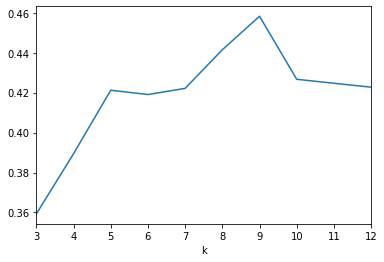

In [533]:
df_data_eval.sils.plot()

/Users/alamhanz/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


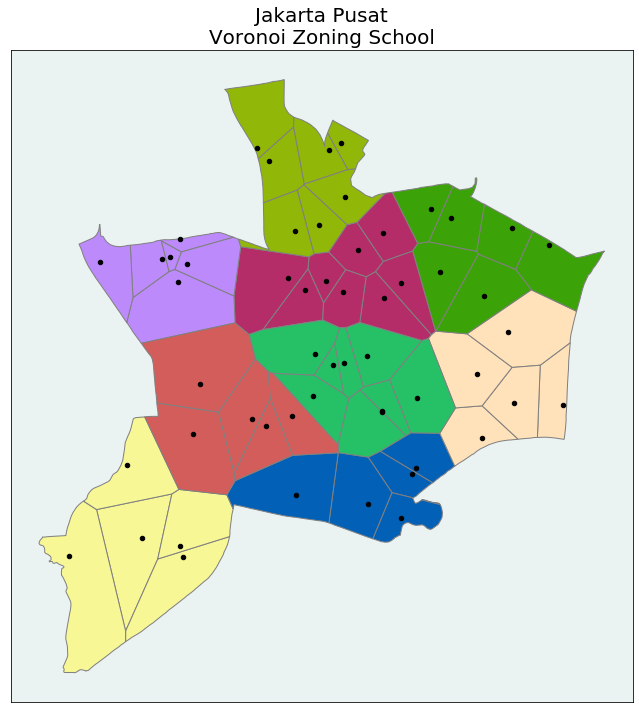

In [534]:
map_df_v=map_df[map_df.NAME_2==kab_n]

poly_v=map_df_v['geometry'].values[0]
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(df_cls_kab[['bujur','lintang']].values, poly_v)

df_cls_kab['col_sort']=get_points_to_poly_assignments(poly_to_pt_assignments)
df_cls_kab['vor']=df_cls_kab.col_sort.apply(lambda x:poly_shapes[x])
cte=df_cls_kab.colvo.unique()

fig, ax = subplot_for_map(figsize=(12,12))
ax.set_facecolor('#EBF2F2')
for cc in df_cls_kab.cls.unique():
    geom_v=df_cls_kab[df_cls_kab.cls==cc]['vor']
    geo_vor=gpd.GeoDataFrame(df_cls_kab[['bujur','lintang']],geometry=geom_v)
    geo_vor.plot(ax=ax,markersize=20,color=cte[cc],edgecolor='grey')

# plot_voronoi_polys_with_points_in_area(ax, poly_v, poly_shapes, df_cls_kab[['bujur','lintang']].values, poly_to_pt_assignments,voronoi_edgecolor='black'
#                                        ,voronoi_and_points_cmap=None,voronoi_color=col_sort,points_color='white')

dsp2=data_merge_map2[(data_merge_map2.bp.str.lower().str.contains('sma'))
            &(data_merge_map2.inside_polyg==1)
            &(data_merge_map2.NAME_2==kab_n)]

XX_v=dsp2[['bujur','lintang']]
XX_v=(XX_v-XX_v.mean())/XX_v.std()
dsp2['cls']=real_KM0.fit_predict(XX_v)

geom1=dsp2['Point']
geo_data_point=gpd.GeoDataFrame(dsp2,geometry=geom1)
geo_data_point.plot(ax=ax,markersize=20,color='black',label='SMA')
    
plt.title(kab_n+"\nVoronoi Zoning School",{'fontsize':20})
plt.show()